<a href="https://colab.research.google.com/github/AlexKI123/OnlineChallengeStockMarket/blob/main/LearningRateFinder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 53, 100)           40800     
                                                                 
 lstm_11 (LSTM)              (None, 50)                30200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_10 (Dense)            (None, 64)                3264      
                                                                 
 dense_11 (Dense)            (None, 3)                 195       
                                                                 
Total params: 74459 (290.86 KB)
Trainable params: 74459 (290.86 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
4217/4217 [

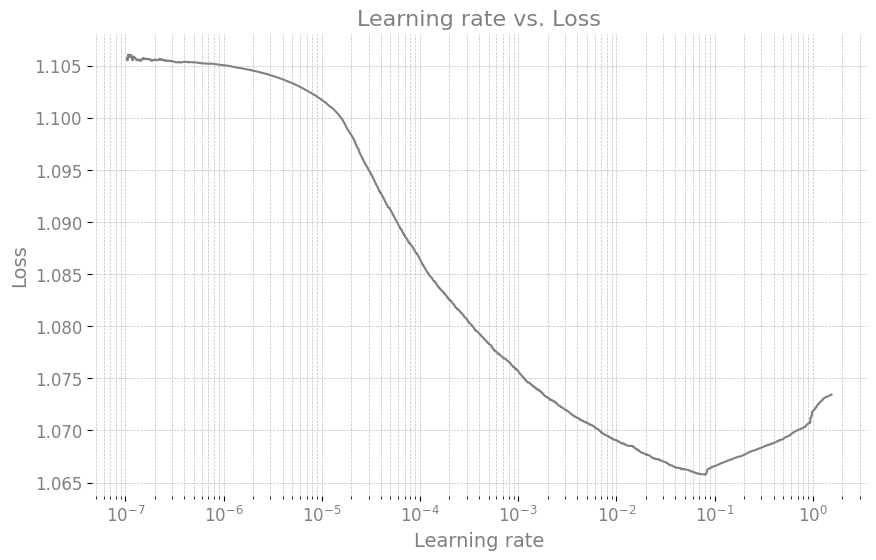

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import Callback


# Learning Rate Finder Implementation
# -----------------------------------
# This script demonstrates the use of a Learning Rate Finder, a technique to identify the optimal learning rate range for training deep learning models.
# The Learning Rate Finder gradually increases the learning rate from a lower bound to an upper bound during training and monitors the loss.
# By plotting the loss against the learning rate, we can observe where the loss decreases most rapidly and select an effective learning rate for model training.
# This approach helps in optimizing the training process, potentially leading to better model performance and faster convergence.


class LRFinder(Callback):
    """
    A simple callback for finding the optimal learning rate range for your model + dataset.
    """
    def __init__(self, start_lr=1e-7, end_lr=1, dataset_size=None, batch_size=None, beta=0.98, use_full_dataset=True):
        super().__init__()
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.beta = beta
        self.batch_size = batch_size
        # If not using the full dataset, adjust 'dataset_size' accordingly before passing
        self.dataset_size = dataset_size if use_full_dataset else int(dataset_size * 0.9) # Example adjustment for 90% of data
        self.steps = self.calculate_steps()
        self.lr_mult = (end_lr / start_lr) ** (1 / self.steps)
        self.avg_loss = 0
        self.best_loss = 0
        self.batch_num = 0
        self.losses = []
        self.lrs = []

    def calculate_steps(self):
        if self.dataset_size and self.batch_size:
            return self.dataset_size // self.batch_size
        else:
            raise ValueError("Dataset size and batch size must be provided to automatically calculate steps.")


    def on_train_begin(self, logs=None):
        tf.keras.backend.set_value(self.model.optimizer.lr, self.start_lr)

    def on_batch_end(self, batch, logs=None):
        self.batch_num += 1
        lr = tf.keras.backend.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        loss = logs['loss']
        self.avg_loss = self.beta * self.avg_loss + (1 - self.beta) * loss
        smoothed_loss = self.avg_loss / (1 - self.beta ** self.batch_num)

        if self.batch_num > 1 and smoothed_loss > self.best_loss * 4:
            self.model.stop_training = True
            return

        if smoothed_loss < self.best_loss or self.batch_num == 1:
            self.best_loss = smoothed_loss

        self.losses.append(smoothed_loss)
        lr *= self.lr_mult
        tf.keras.backend.set_value(self.model.optimizer.lr, lr)

    def plot_loss(self, n_skip_begining=10, n_skip_end=5):
        plt.figure(figsize=(10, 6))
        lrs = self.lrs[n_skip_begining:-n_skip_end] if n_skip_end > 0 else self.lrs[n_skip_begining:]
        losses = self.losses[n_skip_begining:-n_skip_end] if n_skip_end > 0 else self.losses[n_skip_begining:]
        # Ensure that lrs and losses are of the same length
        min_len = min(len(lrs), len(losses))
        plt.plot(lrs[:min_len], losses[:min_len], linestyle='-', color='gray')
        plt.xscale('log')
        plt.xlabel('Learning rate', fontsize=14, fontweight='light', color='gray')
        plt.ylabel('Loss', fontsize=14, fontweight='light', color='gray')
        plt.title('Learning rate vs. Loss', fontsize=16, fontweight='light', color='gray')
        plt.xticks(fontsize=12, color='gray')
        plt.yticks(fontsize=12, color='gray')
        plt.grid(which='both', axis='y', linestyle='--', linewidth=0.5, color='silver')
        plt.grid(which='both', axis='x', linestyle='--', linewidth=0.5, color='silver')
        # Removing the box frame by hiding all spines for a minimalist design
        for spine in plt.gca().spines.values():
            spine.set_visible(False)
        plt.show()



# Assuming the data loading and preprocessing steps remain the same as previously shared
# Load the data
train_data = pd.read_csv('/content/drive/MyDrive/input_training.csv', index_col=0)
train_data_y = pd.read_csv('/content/drive/MyDrive/output_training_gmEd6Zt.csv', index_col=0)

# Merge the input and output data on the 'ID' column
merged_data = train_data.merge(train_data_y, left_index=True, right_index=True)

division_value = 100
columns_to_transform = [f'r{i}' for i in range(53)]
for column in columns_to_transform:
    merged_data[column] = merged_data[column] / division_value
merged_data[columns_to_transform] = np.tanh(merged_data[columns_to_transform])

# Replace NaN values with the mask value
mask_value = -2.0  # Use float explicitly
merged_data.fillna(mask_value, inplace=True)

# Drop the 'day' and 'equity' columns from the DataFrame
merged_data = merged_data.drop(['day', 'equity'], axis=1)

# Map labels from [-1, 0, 1] to [0, 1, 2]
label_mapping = {-1: 0, 0: 1, 1: 2}
merged_data['reod'] = merged_data['reod'].map(label_mapping)

# Prepare the data
X = merged_data.drop('reod', axis=1).values.reshape(-1, 53, 1)  # Reshape for LSTM [samples, time steps, features]
y = to_categorical(merged_data['reod'].values)  # Convert labels to one-hot encoding

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# Define your model architecture here
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(53, 1)),
    LSTM(50),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
print(model.summary())

# Assuming the size of your dataset is the length of X_train
dataset_size = len(X_train)
batch_size = 128  # This should match the batch size used in model.fit

# Initialize the LRFinder with dataset_size and batch_size
lr_finder = LRFinder(start_lr=1e-7, end_lr=1e2, dataset_size=dataset_size, batch_size=batch_size, beta=0)

# Train the model with LRFinder
model.fit(X_train, y_train, epochs=1, batch_size=128, validation_split=0.2, callbacks=[lr_finder])

# After training, plot the loss vs. learning rate
lr_finder.plot_loss()